In [1]:
# Team Leader and Sole Member: Ahmed Khaled Ramadan Mohamed Al Sayyad
# Section: 3

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [3]:
# Load the final dataset
df1 = pd.read_csv('final_attack_capture.csv', on_bad_lines='skip')
df2 = pd.read_csv('final_attack_capture_2.csv', on_bad_lines='skip')

# Assuming df1 and df2 are your DataFrames
df = pd.concat([df1, df2], ignore_index=True)



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4513 entries, 0 to 4512
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   frame.time_epoch              4513 non-null   float64
 1   frame.time_delta              4513 non-null   float64
 2   ip.proto                      3529 non-null   float64
 3   ip.ttl                        3529 non-null   float64
 4   ip.src                        3529 non-null   object 
 5   ip.dst                        3529 non-null   object 
 6   tcp.srcport                   3011 non-null   float64
 7   tcp.dstport                   3011 non-null   float64
 8   udp.srcport                   334 non-null    float64
 9   udp.dstport                   334 non-null    float64
 10  tcp.flags                     3011 non-null   object 
 11  tcp.seq                       3011 non-null   float64
 12  tcp.ack                       3011 non-null   float64
 13  tcp

In [5]:
# Find columns with more than 90% NaN values
threshold = 0.8
nan_percentage = df.isna().mean()  # Calculate the percentage of NaNs in each column
columns_to_drop = nan_percentage[nan_percentage > threshold].index  # Get the column names with more than 90% NaNs

# Drop those columns
df = df.drop(columns=columns_to_drop)

# Display the cleaned DataFrame
print(f"Columns dropped: {list(columns_to_drop)}")
print(df.head())  # Check the first few rows after dropping


Columns dropped: ['udp.srcport', 'udp.dstport', 'tcp.options.mss', 'udp.length']
   frame.time_epoch  frame.time_delta  ip.proto  ip.ttl    ip.src    ip.dst  \
0      1.746868e+09          0.000000       6.0    64.0  10.0.3.5  10.0.3.7   
1      1.746868e+09          0.000020       6.0    64.0  10.0.3.7  10.0.3.5   
2      1.746868e+09          0.000139       6.0    64.0  10.0.3.5  10.0.3.7   
3      1.746868e+09          0.000124      17.0    64.0  10.0.3.7   1.1.1.3   
4      1.746868e+09          0.063802      17.0   255.0   1.1.1.3  10.0.3.7   

   tcp.srcport  tcp.dstport tcp.flags  tcp.seq  tcp.ack  tcp.len  \
0      46681.0       6667.0    0x0002      0.0      0.0      0.0   
1       6667.0      46681.0    0x0012      0.0      1.0      0.0   
2      46681.0       6667.0    0x0010      1.0      1.0      0.0   
3          NaN          NaN       NaN      NaN      NaN      NaN   
4          NaN          NaN       NaN      NaN      NaN      NaN   

   tcp.window_size  tcp.analysis.by

In [6]:
df.head()

,frame.time_epoch,frame.time_delta,ip.proto,ip.ttl,ip.src,ip.dst,tcp.srcport,tcp.dstport,tcp.flags,tcp.seq,tcp.ack,tcp.len,tcp.window_size,tcp.analysis.bytes_in_flight,frame.len,label
0,1.746868e+09,0.000000,6.0,64.0,10.0.3.5,10.0.3.7,46681.0,6667.0,0x0002,0.0,0.0,0.0,64240.0,NaN,74,1
1,1.746868e+09,0.000020,6.0,64.0,10.0.3.7,10.0.3.5,6667.0,46681.0,0x0012,0.0,1.0,0.0,5792.0,NaN,74,1
2,1.746868e+09,0.000139,6.0,64.0,10.0.3.5,10.0.3.7,46681.0,6667.0,0x0010,1.0,1.0,0.0,64256.0,NaN,66,1
3,1.746868e+09,0.000124,17.0,64.0,10.0.3.7,1.1.1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,1
4,1.746868e+09,0.063802,17.0,255.0,1.1.1.3,10.0.3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,1


In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode IP addresses as integers (for both source and destination IPs)
le_src = LabelEncoder()
le_dst = LabelEncoder()

df['ip.src_encoded'] = le_src.fit_transform(df['ip.src'])
df['ip.dst_encoded'] = le_dst.fit_transform(df['ip.dst'])

# Drop the original IP columns
df = df.drop(columns=['ip.src', 'ip.dst', 'frame.time_epoch'])


In [8]:
def clean_tcp_flag(x):
    try:
        # Convert to string and clean
        s = str(x).strip().lower()
        if s.startswith('0x'):
            return int(s, 16)
        elif s.isdigit():
            return int(s)
    except:
        pass
    return 0  # default value for NaN, invalid, etc.

# Apply the function safely
df['tcp.flags'] = df['tcp.flags'].apply(clean_tcp_flag)

In [9]:
df.head()

,frame.time_delta,ip.proto,ip.ttl,tcp.srcport,tcp.dstport,tcp.flags,tcp.seq,tcp.ack,tcp.len,tcp.window_size,tcp.analysis.bytes_in_flight,frame.len,label,ip.src_encoded,ip.dst_encoded
0,0.000000,6.0,64.0,46681.0,6667.0,2,0.0,0.0,0.0,64240.0,NaN,74,1,4,7
1,0.000020,6.0,64.0,6667.0,46681.0,18,0.0,1.0,0.0,5792.0,NaN,74,1,6,5
2,0.000139,6.0,64.0,46681.0,6667.0,16,1.0,1.0,0.0,64256.0,NaN,66,1,4,7
3,0.000124,17.0,64.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,81,1,6,0
4,0.063802,17.0,255.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,81,1,0,7


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4513 entries, 0 to 4512
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   frame.time_delta              4513 non-null   float64
 1   ip.proto                      3529 non-null   float64
 2   ip.ttl                        3529 non-null   float64
 3   tcp.srcport                   3011 non-null   float64
 4   tcp.dstport                   3011 non-null   float64
 5   tcp.flags                     4513 non-null   int64  
 6   tcp.seq                       3011 non-null   float64
 7   tcp.ack                       3011 non-null   float64
 8   tcp.len                       3011 non-null   float64
 9   tcp.window_size               3011 non-null   float64
 10  tcp.analysis.bytes_in_flight  1280 non-null   float64
 11  frame.len                     4513 non-null   int64  
 12  label                         4513 non-null   int64  
 13  ip.

In [11]:
df.head()

,frame.time_delta,ip.proto,ip.ttl,tcp.srcport,tcp.dstport,tcp.flags,tcp.seq,tcp.ack,tcp.len,tcp.window_size,tcp.analysis.bytes_in_flight,frame.len,label,ip.src_encoded,ip.dst_encoded
0,0.000000,6.0,64.0,46681.0,6667.0,2,0.0,0.0,0.0,64240.0,NaN,74,1,4,7
1,0.000020,6.0,64.0,6667.0,46681.0,18,0.0,1.0,0.0,5792.0,NaN,74,1,6,5
2,0.000139,6.0,64.0,46681.0,6667.0,16,1.0,1.0,0.0,64256.0,NaN,66,1,4,7
3,0.000124,17.0,64.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,81,1,6,0
4,0.063802,17.0,255.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,81,1,0,7


In [12]:
df.duplicated().sum()

np.int64(358)

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df.columns

Index(['frame.time_delta', 'ip.proto', 'ip.ttl', 'tcp.srcport', 'tcp.dstport',
       'tcp.flags', 'tcp.seq', 'tcp.ack', 'tcp.len', 'tcp.window_size',
       'tcp.analysis.bytes_in_flight', 'frame.len', 'label', 'ip.src_encoded',
       'ip.dst_encoded'],
      dtype='object')

In [16]:
# Assuming your label column is named 'label'
label_counts = df['label'].value_counts()

print("Number of '1' labels (attack):", label_counts.get(1, 0))
print("Number of '0' labels (normal):", label_counts.get(0, 0))


Number of '1' labels (attack): 2929
Number of '0' labels (normal): 1226


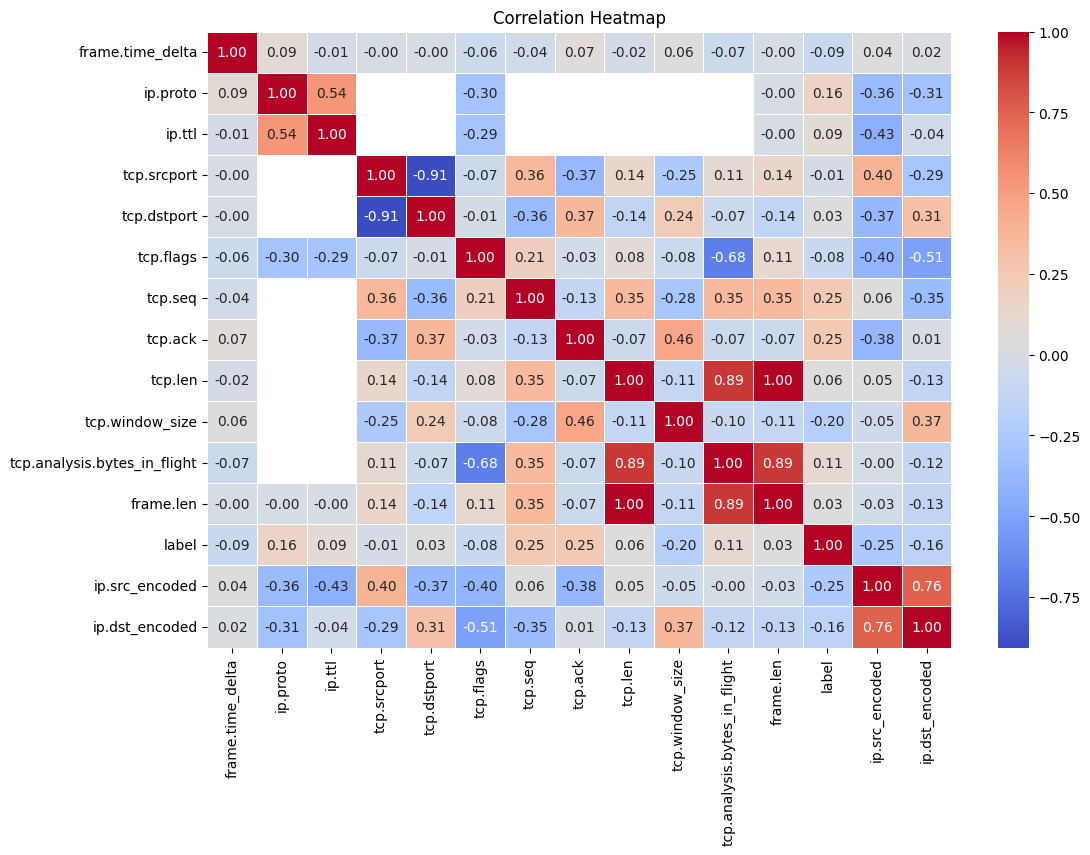

In [17]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)

# Display the plot
plt.title("Correlation Heatmap")
plt.show()

In [18]:
# Handle class imbalance: Calculate class weights
#class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y)
#class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Print class weights
#print(class_weight_dict)

In [19]:
# Separate features and labels
X = df.drop(columns=['label'])
y = df['label']

In [20]:
imputer = SimpleImputer(strategy='median')
X= imputer.fit_transform(X)

In [21]:
print(X[:5])  # Shows first 5 rows

[[0.0000e+00 6.0000e+00 6.4000e+01 4.6681e+04 6.6670e+03 2.0000e+00
  0.0000e+00 0.0000e+00 0.0000e+00 6.4240e+04 5.2000e+01 7.4000e+01
  4.0000e+00 7.0000e+00]
 [2.0000e-05 6.0000e+00 6.4000e+01 6.6670e+03 4.6681e+04 1.8000e+01
  0.0000e+00 1.0000e+00 0.0000e+00 5.7920e+03 5.2000e+01 7.4000e+01
  6.0000e+00 5.0000e+00]
 [1.3900e-04 6.0000e+00 6.4000e+01 4.6681e+04 6.6670e+03 1.6000e+01
  1.0000e+00 1.0000e+00 0.0000e+00 6.4256e+04 5.2000e+01 6.6000e+01
  4.0000e+00 7.0000e+00]
 [1.2400e-04 1.7000e+01 6.4000e+01 3.8218e+04 3.5581e+04 0.0000e+00
  1.0600e+02 1.3400e+02 0.0000e+00 6.9120e+03 5.2000e+01 8.1000e+01
  6.0000e+00 0.0000e+00]
 [6.3802e-02 1.7000e+01 2.5500e+02 3.8218e+04 3.5581e+04 0.0000e+00
  1.0600e+02 1.3400e+02 0.0000e+00 6.9120e+03 5.2000e+01 8.1000e+01
  0.0000e+00 7.0000e+00]]


In [22]:
#print(X.isnull().sum())

In [23]:
# Split the dataset into training and testing sets (60% training, 40% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)



In [24]:
# Standardize the feature data (important for many ML models)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [25]:
# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [26]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print("Model Evaluation:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Model Evaluation:
Accuracy: 0.9199759326113117
Precision: 0.9223300970873787
Recall: 0.9685641461342396
F1 Score: 0.9448818897637795


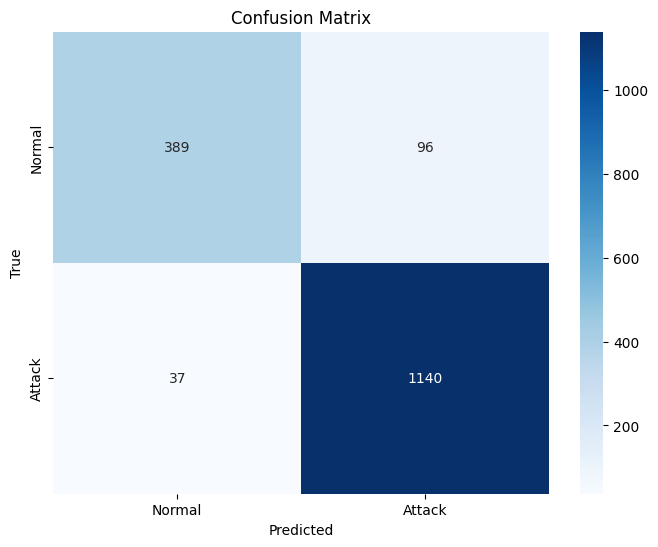

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
from sklearn.model_selection import cross_val_score

# Cross-validation with logistic regression
cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean()}")


Cross-validation scores: [0.90781563 0.91182365 0.91583166 0.91767068 0.91767068]
Mean CV score: 0.9141624614691229


In [29]:
from sklearn.metrics import roc_auc_score

# Calculate AUC score
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC: {roc_auc}")


ROC-AUC: 0.9532999325561231
